In [2]:
import geojson
import geopandas as gpd
import descarteslabs as dl
import pandas as pd
from shapely import geometry
from shapely.ops import cascaded_union
import numpy as np
import json
import yaml
import pickle
import matplotlib.pyplot as plt
gpd.options.use_pygeos=False

- Combine airbus and cv polygons
- get S2-shaped tiles for all polygons
- filter those tiles for only those within airbus tiles

In [13]:
cv_tiles = gpd.read_file('../../data/cv_all_tiles.geojson')
cv_polys = gpd.read_file('../../data/cv_all_polys.geojson')

In [14]:
cv_polys_mp = geometry.MultiPolygon([geom for geom in cv_polys.unary_union.geoms])

In [15]:
cv_tiles_mp =geometry.MultiPolygon([geom for geom in cv_tiles.unary_union.geoms])

### Download pipeline interim features

In [3]:
config = yaml.safe_load(open('../../cloud_products_exec.yaml','r'))

In [8]:
for kk in config.keys():
    print (config[kk]['cloud_id'])

ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v1-solar-pv-20190521-combined-final
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:solar_pv_S2_v3_20190306_primary
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:solar_pv:s2:v3_20190327:secondary
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:V1-solar_pv-S2-20190308-primary_pass
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:V2-solar_pv-S2-20190327-secondary_filter
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:V3-solar_pv-S2-20190328-deepstack
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v4-solar_pv-s2-20190322_final
8514dad6c277e007cedb6fb8e829a23c8975fca4:solar_pv:airbus:spot:v5_0111
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v1b-solar-pv-spot
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v1-solar_pv-spot-20200317-postfilter


In [4]:
vector_keys = [kk for kk in config.keys() if kk.split('-')[1][0]=='V']

In [5]:
vector_keys=vector_keys[1:]

In [6]:
vector_keys

['S2-V1-Primary',
 'S2-V2-Secondary',
 'S2-V3-Deepstack',
 'S2-V4-Final',
 'SPOT-V1-Vectorised',
 'SPOT-V2-Filtered']

In [55]:
for kk in vector_keys:
    fc = dl.vectors.FeatureCollection(config[kk]['cloud_id'])
    fts = [geojson.Feature(geometry=f.geometry, properties=f.properties) for f in fc.filter(cv_tiles_mp).features()]
    print (kk, len(fts))
    json.dump(geojson.FeatureCollection(fts),open('../data/crossvalidation/'+kk+'.geojson','w'))

S2-V1-Primary 2365
S2-V2-Secondary 2311
S2-V3-Deepstack 882
S2-V4-Final 449
SPOT-V1-Vectorised 1095
SPOT-V2-Filtered 398


### Get final product

In [5]:
final_polys=gpd.read_file('../data/ABCD_simplified.geojson')

In [7]:
final_polys = final_polys[final_polys.intersects(cv_mp)]

In [45]:
final_polys.to_file('../data/crossvalidation/compile_final.geojson',driver='GeoJSON')

### Load downloaded features

In [7]:
gdfs = {}
for kk in vector_keys:
    gdfs[kk] = gpd.read_file('../../data/crossvalidation/'+kk+'.geojson')
gdfs['compiled_final']=gpd.read_file('../../data/crossvalidation/compile_final.geojson')

#### Get Area

In [16]:
cv_polys['geoarea'] = cv_polys.to_crs({'init': 'epsg:3857'}).area

In [8]:
for kk in gdfs.keys():
    gdfs[kk]['geoarea'] = gdfs[kk].to_crs({'init': 'epsg:3857'}).area

/home/lucas/miniconda3/envs/sips/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Some filters on S2: >30m^2; cascade-union-reset

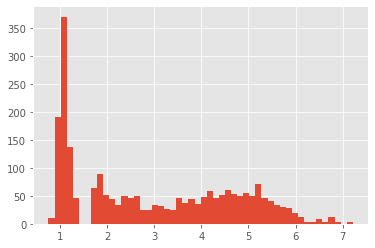

In [30]:
np.log10(gdfs['S2-V2-Secondary']['geoarea']).hist(bins=50)

In [31]:
res = np.histogram(np.log10(gdfs['S2-V2-Secondary']['geoarea']), bins=50)

In [32]:
print (list(zip(10**res[1],res[0])))

[(5.674730474538771, 11), (7.640726897427891, 191), (10.287837948078597, 371), (13.852034114915817, 137), (18.651037282000335, 46), (25.112643299079867, 0), (33.812856836409885, 0), (45.52723796628138, 65), (61.30003764149516, 90), (82.53728499039997, 51), (111.13212447646303, 45), (149.6335758086609, 34), (201.4737603079688, 50), (271.27384928993587, 46), (365.25600751230024, 50), (491.7980534173634, 25), (662.180280051828, 24), (891.5910102584322, 33), (1200.4805239917946, 32), (1616.3840504245206, 26), (2176.376331187056, 25), (2930.376561008026, 46), (3945.59831691497, 38), (5312.541154467555, 45), (7153.057977776832, 36), (9631.217330035897, 48), (12967.92889790243, 58), (17460.63598592121, 47), (23509.830400300918, 52), (31654.75334899443, 61), (42621.464830850105, 53), (57387.5665464661, 49), (77269.34790240515, 55), (104039.12353433961, 49), (140083.22212664405, 72), (188614.7100701572, 47), (253959.8127082406, 41), (341943.56551943894, 33), (460409.0732043322, 30), (619916.664

In [9]:
for key in ['S2-V1-Primary','S2-V2-Secondary', 'S2-V3-Deepstack', 'S2-V4-Final']:
    gdfs[key] = gdfs[key][gdfs[key]['geoarea']>30]
    mp = cascaded_union( gdfs[key].geometry.values)
    print (key, len(list(mp)))
    gdfs[key] = gpd.GeoDataFrame(geometry=list(mp), crs={'init': 'epsg:4326'})
    gdfs[key]['geoarea'] = gdfs[key].to_crs({'init': 'epsg:3857'}).area

S2-V1-Primary 1103
S2-V2-Secondary 986
S2-V3-Deepstack 546
S2-V4-Final 309


### precision / recall

In [35]:
area_bins = [30,1e2,1e3,1e4,1e5,1e6,1e10]

In [37]:
area_bins = [1e4, 1e10]

In [38]:
res_dict= {}

In [39]:

for kk,gdf in gdfs.items():
    res_dict[kk] = {}
    pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    for ii_a in range(len(area_bins)-1):
        res_dict[kk][ii_a] = {}
        # precision = TP/(TP+FP)
        bin_slice = gdf[(gdf.geoarea>=area_bins[ii_a]) & (gdf.geoarea<area_bins[ii_a+1])]
        intersects = bin_slice.intersects(cv_polys_mp)
        TP = np.sum(intersects)
        FP = np.sum(~intersects)
        res_dict[kk][ii_a]['P']=TP/(TP+FP)
        res_dict[kk][ii_a]['P_TP'] = TP
        res_dict[kk][ii_a]['P_FP'] = FP
        
        # recall = TP / (TP+FN)
        cv_slice = cv_polys[(cv_polys.geoarea>=area_bins[ii_a])&(cv_polys.geoarea<area_bins[ii_a+1])]
        intersects = cv_slice.intersects(pipe_mp)
        TP = np.sum(intersects)
        FN = np.sum(~intersects)
        res_dict[kk][ii_a]['R']=TP/(TP+FN)
        res_dict[kk][ii_a]['R_TP'] = TP
        res_dict[kk][ii_a]['R_FN'] = FN
        
        
        print (kk,area_bins[ii_a],res_dict[kk][ii_a])


S2-V1-Primary 10000.0 {'P': 0.8069815195071869, 'P_TP': 393, 'P_FP': 94, 'R': 0.9435707678075855, 'R_TP': 1020, 'R_FN': 61}
S2-V2-Secondary 10000.0 {'P': 0.8045267489711934, 'P_TP': 391, 'P_FP': 95, 'R': 0.938945420906568, 'R_TP': 1015, 'R_FN': 66}
S2-V3-Deepstack 10000.0 {'P': 0.8459657701711492, 'P_TP': 346, 'P_FP': 63, 'R': 0.8825161887141536, 'R_TP': 954, 'R_FN': 127}
S2-V4-Final 10000.0 {'P': 0.9417808219178082, 'P_TP': 275, 'P_FP': 17, 'R': 0.782608695652174, 'R_TP': 846, 'R_FN': 235}
SPOT-V1-Vectorised 10000.0 {'P': 0.7962616822429907, 'P_TP': 426, 'P_FP': 109, 'R': 0.6623496762257169, 'R_TP': 716, 'R_FN': 365}
SPOT-V2-Filtered 10000.0 {'P': 0.8817204301075269, 'P_TP': 164, 'P_FP': 22, 'R': 0.28862164662349676, 'R_TP': 312, 'R_FN': 769}
compiled_final 10000.0 {'P': 0.9366812227074236, 'P_TP': 429, 'P_FP': 29, 'R': 0.7641073080481036, 'R_TP': 826, 'R_FN': 255}


In [40]:
pickle.dump(res_dict, open('./res_dict_gt10k.pickle','wb'))

In [18]:
crs ={'init': 'epsg:4326'}

**IOU**

In [19]:
# iou
iou_dict = {}
for kk,gdf in gdfs.items():
    iou_dict[kk] = {}
    #pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    for ii_a in range(len(area_bins)-1):
        iou_dict[kk][ii_a] = {}
        # iou = intersection / union
        bindf_slice = gdf[(gdf.geoarea>=area_bins[ii_a]) & (gdf.geoarea<area_bins[ii_a+1])]
        bindf_mp = geometry.MultiPolygon([geom for geom in bindf_slice.unary_union.geoms])
        cv_slice = cv_polys[(cv_polys.geoarea>=area_bins[ii_a])&(cv_polys.geoarea<area_bins[ii_a+1])]
        cv_mp = geometry.MultiPolygon([geom for geom in cv_slice.unary_union.geoms])
        
        intersection=bindf_mp.intersection(cv_mp)
        union=bindf_mp.union(cv_mp)
        

        if not intersection.is_empty:
            #print (intersection)
        
            if intersection.type=='Polygon':
                
                i_gdf = gpd.GeoDataFrame(geometry=[intersection], crs=crs)
            else:
                i_gdf = gpd.GeoDataFrame(geometry=list(intersection), crs=crs)

            if union.type=='Polygon':
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)
            else:
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)

            i_gdf['geoarea'] = i_gdf.to_crs({'init': 'epsg:3857'}).area
            u_gdf['geoarea'] = u_gdf.to_crs({'init': 'epsg:3857'}).area

            iou_dict[kk][ii_a]['iou'] = i_gdf['geoarea'].sum() / u_gdf['geoarea'].sum()
            
        else:
            iou_dict[kk][ii_a]['iou'] = 0
        
        
        print (kk,area_bins[ii_a],iou_dict[kk][ii_a])

S2-V1-Primary 10000.0 {'iou': 0.6601138239508704}
S2-V2-Secondary 10000.0 {'iou': 0.6620037659918535}
S2-V3-Deepstack 10000.0 {'iou': 0.6349789967074572}
S2-V4-Final 10000.0 {'iou': 0.6231999621351502}
SPOT-V1-Vectorised 10000.0 {'iou': 0.3695013576278666}
SPOT-V2-Filtered 10000.0 {'iou': 0.1565628288469313}
compiled_final 10000.0 {'iou': 0.6646446098512562}


In [20]:
for kk,gdf in gdfs.items():
    #pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    for ii_a in range(len(area_bins)-1):
        # iou = intersection / union
        bindf_slice = gdf[gdf.geoarea<area_bins[ii_a+1]]
        bindf_mp = geometry.MultiPolygon([geom for geom in bindf_slice.unary_union.geoms])
        cv_slice = cv_polys[cv_polys.geoarea<area_bins[ii_a+1]]
        cv_mp = geometry.MultiPolygon([geom for geom in cv_slice.unary_union.geoms])
        
        intersection=bindf_mp.intersection(cv_mp)
        union=bindf_mp.union(cv_mp)
        

        if not intersection.is_empty:
            #print (intersection)
        
            if intersection.type=='Polygon':
                
                i_gdf = gpd.GeoDataFrame(geometry=[intersection], crs=crs)
            else:
                i_gdf = gpd.GeoDataFrame(geometry=list(intersection), crs=crs)

            if union.type=='Polygon':
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)
            else:
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)

            i_gdf['geoarea'] = i_gdf.to_crs({'init': 'epsg:3857'}).area
            u_gdf['geoarea'] = u_gdf.to_crs({'init': 'epsg:3857'}).area

            iou_dict[kk][ii_a]['iou_neg'] = i_gdf['geoarea'].sum() / u_gdf['geoarea'].sum()
            
        else:
            iou_dict[kk][ii_a]['iou_neg'] = 0
        
        
        print (kk,area_bins[ii_a],iou_dict[kk][ii_a])

S2-V1-Primary 10000.0 {'iou': 0.6601138239508704, 'iou_neg': 0.6563951137408393}
S2-V2-Secondary 10000.0 {'iou': 0.6620037659918535, 'iou_neg': 0.6582870498190418}
S2-V3-Deepstack 10000.0 {'iou': 0.6349789967074572, 'iou_neg': 0.6314677164262166}
S2-V4-Final 10000.0 {'iou': 0.6231999621351502, 'iou_neg': 0.6181659415927192}
SPOT-V1-Vectorised 10000.0 {'iou': 0.3695013576278666, 'iou_neg': 0.36967683216591196}
SPOT-V2-Filtered 10000.0 {'iou': 0.1565628288469313, 'iou_neg': 0.15876753036408528}
compiled_final 10000.0 {'iou': 0.6646446098512562, 'iou_neg': 0.660817667864235}


In [21]:
pickle.dump(iou_dict, open('./iou_dict_gt10k.pickle','wb'))

In [22]:
iou_dict

{'S2-V1-Primary': {0: {'iou': 0.6601138239508704,
   'iou_neg': 0.6563951137408393}},
 'S2-V2-Secondary': {0: {'iou': 0.6620037659918535,
   'iou_neg': 0.6582870498190418}},
 'S2-V3-Deepstack': {0: {'iou': 0.6349789967074572,
   'iou_neg': 0.6314677164262166}},
 'S2-V4-Final': {0: {'iou': 0.6231999621351502,
   'iou_neg': 0.6181659415927192}},
 'SPOT-V1-Vectorised': {0: {'iou': 0.3695013576278666,
   'iou_neg': 0.36967683216591196}},
 'SPOT-V2-Filtered': {0: {'iou': 0.1565628288469313,
   'iou_neg': 0.15876753036408528}},
 'compiled_final': {0: {'iou': 0.6646446098512562,
   'iou_neg': 0.660817667864235}}}

### Plot Data

In [24]:
res_dict = pickle.load(open('./res_dict_2020-04-07.pkl','rb'))# open('../../data/res_dict.pkl','rb'))
iou_dict = pickle.load(open('./iou_dict_2020-04-07.pickle','rb'))# open('../../data/iou_dict.pickle','rb'))

In [25]:
for key, vv in res_dict.items():
    for ar,vv2 in vv.items():
        vv2['iou'] = iou_dict[key][ar]['iou']
        vv2['iou_neg'] = iou_dict[key][ar]['iou_neg']
        #vv2['iou_pos'] = iou_dict[key][ar]['iou_pos']

In [26]:
res_dict

{'S2-V1-Primary': {0: {'P': 0.11904761904761904,
   'P_TP': 20,
   'P_FP': 148,
   'R': 0.054901960784313725,
   'R_TP': 112,
   'R_FN': 1928,
   'iou': 0,
   'iou_neg': 0},
  1: {'P': 0.17391304347826086,
   'P_TP': 44,
   'P_FP': 209,
   'R': 0.25051334702258726,
   'R_TP': 488,
   'R_FN': 1460,
   'iou': 0,
   'iou_neg': 0},
  2: {'P': 0.3076923076923077,
   'P_TP': 60,
   'P_FP': 135,
   'R': 0.34299516908212563,
   'R_TP': 284,
   'R_FN': 544,
   'iou': 0.04842197089545483,
   'iou_neg': 0.043142154608858625},
  3: {'P': 0.740072202166065,
   'P_TP': 205,
   'P_FP': 72,
   'R': 0.9115191986644408,
   'R_TP': 546,
   'R_FN': 53,
   'iou': 0.2653663715828194,
   'iou_neg': 0.26777552884348144},
  4: {'P': 0.8857142857142857,
   'P_TP': 155,
   'P_FP': 20,
   'R': 0.9814385150812065,
   'R_TP': 423,
   'R_FN': 8,
   'iou': 0.3455823731445,
   'iou_neg': 0.37640851232499656},
  5: {'P': 0.9428571428571428,
   'P_TP': 33,
   'P_FP': 2,
   'R': 1.0,
   'R_TP': 51,
   'R_FN': 0,
   'iou'

In [27]:
iou_dict

{'S2-V1-Primary': {0: {'iou': 0, 'iou_neg': 0},
  1: {'iou': 0, 'iou_neg': 0},
  2: {'iou': 0.04842197089545483, 'iou_neg': 0.043142154608858625},
  3: {'iou': 0.2653663715828194, 'iou_neg': 0.26777552884348144},
  4: {'iou': 0.3455823731445, 'iou_neg': 0.37640851232499656},
  5: {'iou': 0.3364447117616685, 'iou_neg': 0.6563951137408393}},
 'S2-V2-Secondary': {0: {'iou': 0, 'iou_neg': 0},
  1: {'iou': 0.00013033784295686285, 'iou_neg': 0.00020296686060219615},
  2: {'iou': 0.04944479718399239, 'iou_neg': 0.04413879313336705},
  3: {'iou': 0.2646407461855996, 'iou_neg': 0.2671610611766822},
  4: {'iou': 0.3463247263440033, 'iou_neg': 0.3759812001682425},
  5: {'iou': 0.3380914159406726, 'iou_neg': 0.6582870498190418}},
 'S2-V3-Deepstack': {0: {'iou': 0, 'iou_neg': 0},
  1: {'iou': 0.00014645965677867912, 'iou_neg': 0.00022717857947077066},
  2: {'iou': 0.026523989020220066, 'iou_neg': 0.02244462009212811},
  3: {'iou': 0.2538674717770279, 'iou_neg': 0.2520082874548917},
  4: {'iou': 0.3

In [28]:
from matplotlib.collections import LineCollection

In [29]:
title_dict = {'P':'Precision','R':'Recall','iou_neg':'Intersection-over-Union'}

In [30]:
plt.style.use('ggplot')

In [31]:
def hex2rgb(h):
    h = h.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]

In [32]:
gg_colors = [tuple(ih/255 for ih in hex2rgb(ii['color'])) for ii in list(plt.rcParams['axes.prop_cycle'])[0:3]]

In [33]:
gg_colors

[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
 (0.596078431372549, 0.5568627450980392, 0.8352941176470589)]

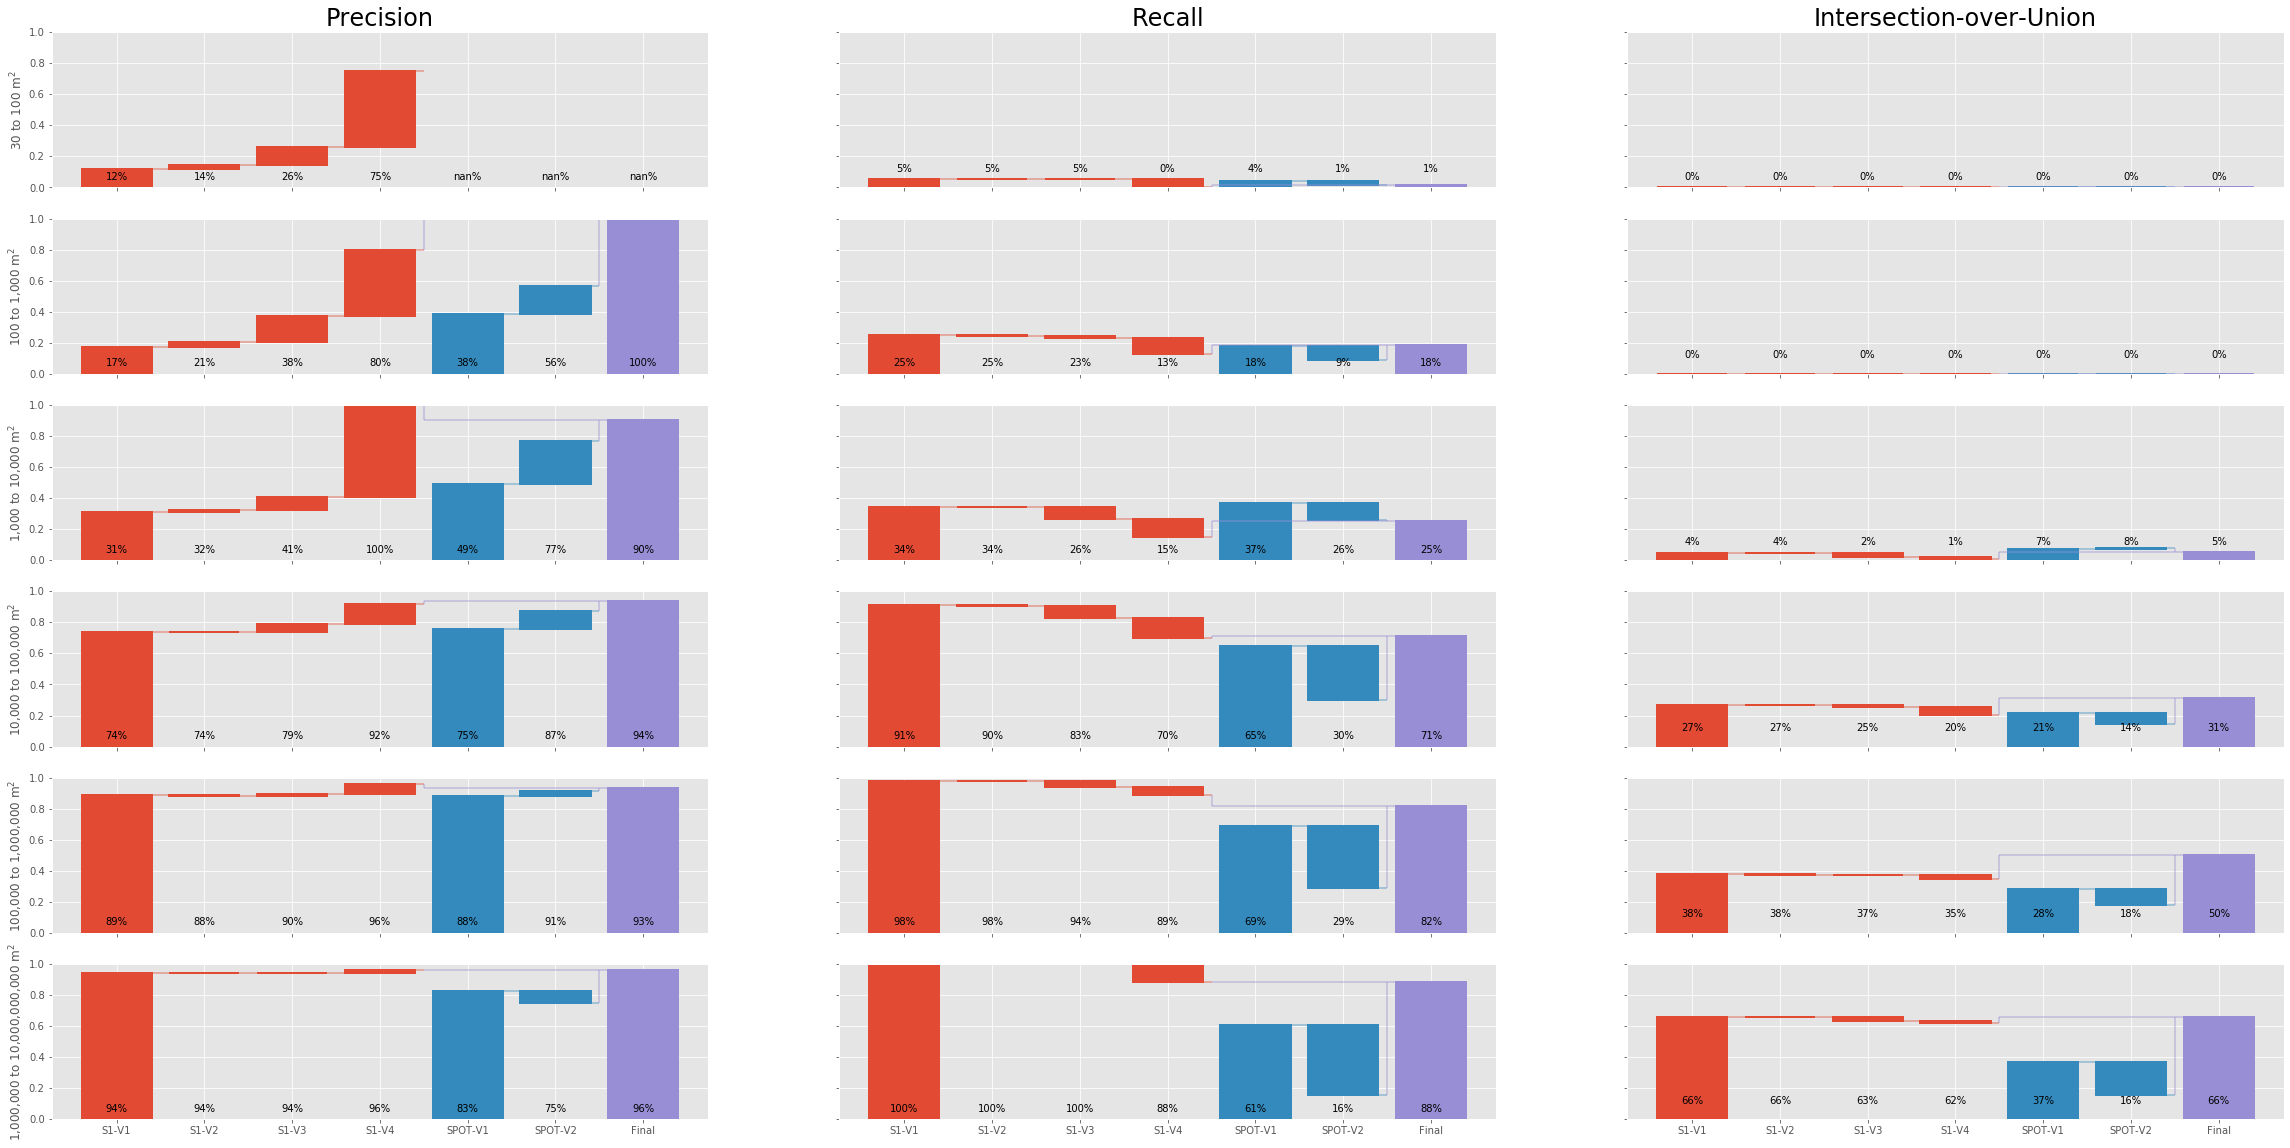

In [36]:
fig, axs = plt.subplots(len(area_bins)-1,3,figsize=(40,20),sharey=True, sharex=True)
# plot P
for ii_a in range(len(area_bins)-1):
    
    for ii_ax, M in enumerate(['P','R','iou_neg']):
        full_bars= [res_dict[kk][ii_a][M] for kk in gdfs.keys()] 

        bars = [full_bars[0]] + \
            [(full_bars[ii] - full_bars[ii-1]) for ii in range(1,4)] + \
            [full_bars[4], full_bars[5]-full_bars[4]] +\
            [full_bars[6]]
        bottoms = [0]+\
                    [full_bars[ii-1] for ii in range(1,4)] +\
                    [0,full_bars[4],0]
        
        lines_y = [el for el in full_bars for _ in (0,1)]
        lines_x = [0] + [el for el in range(1,6) for _ in (0,1)] + [6]
        segs = [[[lines_x[ii], lines_y[ii]],[lines_x[ii+1],lines_y[ii+1]]] for ii in range(0,12,2)]
        
        segs[3][1][0]=3.5
        segs[5][1][0]=5.5
        segs.append([segs[3][1],[segs[3][1][0],full_bars[6]]])
        segs.append([[segs[3][1][0],full_bars[6]],[6,full_bars[6]]])
        segs.append([segs[5][1],[segs[5][1][0],full_bars[6]]])
        
        
        line_segments = LineCollection(segs, colors=[gg_colors[0]]*4 + [gg_colors[1]]*2 + [gg_colors[2]]*3, alpha=0.5)
        axs[ii_a,ii_ax].add_collection(line_segments)

        colors = [gg_colors[0]]*4 + [gg_colors[1]]*2 + [gg_colors[2]]


        axs[ii_a,ii_ax].bar(range(len(gdfs.keys())),bars, bottom=bottoms, edgecolor=colors, linewidth=2,color=colors)
        
        for ii in range(7):
            H=0.05
            if ((M=='R' and ii_a==0) or (M=='iou_neg' and ii_a)):
                H=.1
                
            axs[ii_a,ii_ax].text(ii,H,f'{full_bars[ii]:.0%}', horizontalalignment='center')

        
        axs[ii_a,ii_ax].set_xticklabels(['','S1-V1','S1-V2','S1-V3','S1-V4','SPOT-V1','SPOT-V2','Final'])
        
        if ii_a==0:
            axs[ii_a,ii_ax].set_title(title_dict[M],fontsize=24)
            axs[ii_a,ii_ax].set_ylim([0,1])
        
    axs[ii_a,0].set_ylabel(f'{area_bins[ii_a]:,.0f} to {area_bins[ii_a+1]:,.0f} m$^2$')
    
fig.savefig('../analysis/P-R-iou.png')

### Single measure 10k+

In [42]:
res_dict = pickle.load(open('./res_dict_gt10k.pickle','rb'))# open('../../data/res_dict.pkl','rb'))
iou_dict = pickle.load(open('./iou_dict_gt10k.pickle','rb'))# open('../../data/iou_dict.pickle','rb'))

In [43]:
for key, vv in res_dict.items():
    for ar,vv2 in vv.items():
        vv2['iou'] = iou_dict[key][ar]['iou']
        vv2['iou_neg'] = iou_dict[key][ar]['iou_neg']
        #vv2['iou_pos'] = iou_dict[key][ar]['iou_pos']

In [44]:
res_dict

{'S2-V1-Primary': {0: {'P': 0.8069815195071869,
   'P_TP': 393,
   'P_FP': 94,
   'R': 0.9435707678075855,
   'R_TP': 1020,
   'R_FN': 61,
   'iou': 0.6601138239508704,
   'iou_neg': 0.6563951137408393}},
 'S2-V2-Secondary': {0: {'P': 0.8045267489711934,
   'P_TP': 391,
   'P_FP': 95,
   'R': 0.938945420906568,
   'R_TP': 1015,
   'R_FN': 66,
   'iou': 0.6620037659918535,
   'iou_neg': 0.6582870498190418}},
 'S2-V3-Deepstack': {0: {'P': 0.8459657701711492,
   'P_TP': 346,
   'P_FP': 63,
   'R': 0.8825161887141536,
   'R_TP': 954,
   'R_FN': 127,
   'iou': 0.6349789967074572,
   'iou_neg': 0.6314677164262166}},
 'S2-V4-Final': {0: {'P': 0.9417808219178082,
   'P_TP': 275,
   'P_FP': 17,
   'R': 0.782608695652174,
   'R_TP': 846,
   'R_FN': 235,
   'iou': 0.6231999621351502,
   'iou_neg': 0.6181659415927192}},
 'SPOT-V1-Vectorised': {0: {'P': 0.7962616822429907,
   'P_TP': 426,
   'P_FP': 109,
   'R': 0.6623496762257169,
   'R_TP': 716,
   'R_FN': 365,
   'iou': 0.3695013576278666,
   'i

In [45]:
iou_dict

{'S2-V1-Primary': {0: {'iou': 0.6601138239508704,
   'iou_neg': 0.6563951137408393}},
 'S2-V2-Secondary': {0: {'iou': 0.6620037659918535,
   'iou_neg': 0.6582870498190418}},
 'S2-V3-Deepstack': {0: {'iou': 0.6349789967074572,
   'iou_neg': 0.6314677164262166}},
 'S2-V4-Final': {0: {'iou': 0.6231999621351502,
   'iou_neg': 0.6181659415927192}},
 'SPOT-V1-Vectorised': {0: {'iou': 0.3695013576278666,
   'iou_neg': 0.36967683216591196}},
 'SPOT-V2-Filtered': {0: {'iou': 0.1565628288469313,
   'iou_neg': 0.15876753036408528}},
 'compiled_final': {0: {'iou': 0.6646446098512562,
   'iou_neg': 0.660817667864235}}}

In [62]:
from matplotlib.collections import LineCollection
import matplotlib.ticker as mtick

In [47]:
title_dict = {'P':'Precision','R':'Recall','iou_neg':'Intersection-over-Union'}

In [48]:
plt.style.use('ggplot')

In [49]:
def hex2rgb(h):
    h = h.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]

In [50]:
gg_colors = [tuple(ih/255 for ih in hex2rgb(ii['color'])) for ii in list(plt.rcParams['axes.prop_cycle'])[0:3]]

In [51]:
gg_colors

[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
 (0.596078431372549, 0.5568627450980392, 0.8352941176470589)]

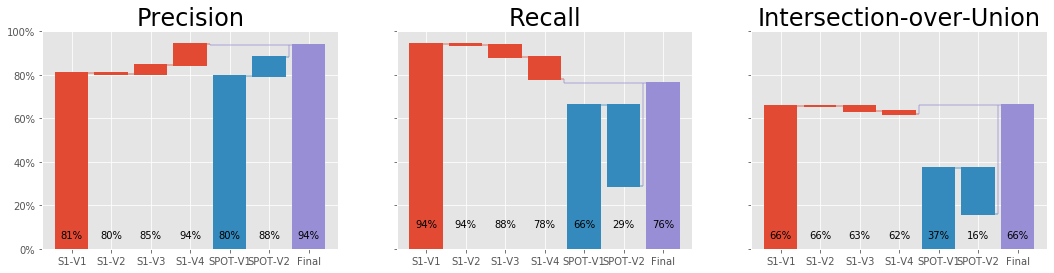

In [65]:
fig, axs = plt.subplots(len(area_bins)-1,3,figsize=(18,4),sharey=True, sharex=True)
axs = axs.reshape((1,-1))
# plot P
for ii_a in range(len(area_bins)-1):
    
    for ii_ax, M in enumerate(['P','R','iou_neg']):
        full_bars= [res_dict[kk][ii_a][M] for kk in gdfs.keys()] 

        bars = [full_bars[0]] + \
            [(full_bars[ii] - full_bars[ii-1]) for ii in range(1,4)] + \
            [full_bars[4], full_bars[5]-full_bars[4]] +\
            [full_bars[6]]
        bottoms = [0]+\
                    [full_bars[ii-1] for ii in range(1,4)] +\
                    [0,full_bars[4],0]
        
        lines_y = [el for el in full_bars for _ in (0,1)]
        lines_x = [0] + [el for el in range(1,6) for _ in (0,1)] + [6]
        segs = [[[lines_x[ii], lines_y[ii]],[lines_x[ii+1],lines_y[ii+1]]] for ii in range(0,12,2)]
        
        segs[3][1][0]=3.5
        segs[5][1][0]=5.5
        segs.append([segs[3][1],[segs[3][1][0],full_bars[6]]])
        segs.append([[segs[3][1][0],full_bars[6]],[6,full_bars[6]]])
        segs.append([segs[5][1],[segs[5][1][0],full_bars[6]]])
        
        
        line_segments = LineCollection(segs, colors=[gg_colors[0]]*4 + [gg_colors[1]]*2 + [gg_colors[2]]*3, alpha=0.5)
        axs[ii_a,ii_ax].add_collection(line_segments)

        colors = [gg_colors[0]]*4 + [gg_colors[1]]*2 + [gg_colors[2]]


        axs[ii_a,ii_ax].bar(range(len(gdfs.keys())),bars, bottom=bottoms, edgecolor=colors, linewidth=2,color=colors)
        
        for ii in range(7):
            H=0.05
            if ((M=='R' and ii_a==0) or (M=='iou_neg' and ii_a)):
                H=.1
                
            axs[ii_a,ii_ax].text(ii,H,f'{full_bars[ii]:.0%}', horizontalalignment='center')

        
        axs[ii_a,ii_ax].set_xticklabels(['','S1-V1','S1-V2','S1-V3','S1-V4','SPOT-V1','SPOT-V2','Final'])
        
        if ii_a==0:
            axs[ii_a,ii_ax].set_title(title_dict[M],fontsize=24)
            axs[ii_a,ii_ax].set_ylim([0,1])
            


    axs[ii_a,0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
        
    #axs[ii_a,0].set_ylabel(f'Installation area > 10,000m$^2$')
    
fig.savefig('../analysis/P-R-iou_single.png')